In [2]:
import os
import numpy as np
import pandas as pd
from tqdm import tqdm
from operator import itemgetter
from collections import OrderedDict

from PIL import Image
import seaborn as sns
import matplotlib.pyplot as plt

import torch
from torch import optim,nn
import torch.nn.functional as F
from torchvision import transforms as T,models
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision.utils import make_grid

pd.options.plotting.backend = "plotly"
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [4]:
data = pd.read_csv('sample_labels.csv')
data.head()

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImageWidth,OriginalImageHeight,OriginalImagePixelSpacing_x,OriginalImagePixelSpacing_y
0,00000013_005.png,Emphysema|Infiltration|Pleural_Thickening|Pneu...,5,13,060Y,M,AP,3056,2544,0.139,0.139
1,00000013_026.png,Cardiomegaly|Emphysema,26,13,057Y,M,AP,2500,2048,0.168,0.168
2,00000017_001.png,No Finding,1,17,077Y,M,AP,2500,2048,0.168,0.168
3,00000030_001.png,Atelectasis,1,30,079Y,M,PA,2992,2991,0.143,0.143
4,00000032_001.png,Cardiomegaly|Edema|Effusion,1,32,055Y,F,AP,2500,2048,0.168,0.168


In [5]:
data['Patient Gender'].value_counts().plot.bar()

In [6]:
data['Patient Age'].apply(lambda x : int(x[1:3])).plot.hist()

In [7]:
data['Patient Age'].apply(lambda x : int(x[1:3])).plot.box()

In [8]:
data['View Position'].value_counts().plot.bar()

In [9]:
pathology_list = ['Cardiomegaly','Emphysema','Effusion','Hernia','Nodule','Pneumothorax','Atelectasis','Pleural_Thickening','Mass','Edema','Consolidation','Infiltration','Fibrosis','Pneumonia']

for pathology in pathology_list :
    data[pathology] = data['Finding Labels'].apply(lambda x: 1 if pathology in x else 0)
    
data['No Findings'] = data['Finding Labels'].apply(lambda x: 1 if 'No Finding' in x else 0)

In [10]:
data = data.drop(list(data.iloc[:,1:11].columns.values),axis = 1)
data.iloc[:,1:].sum().plot.barh()

In [11]:
data = data.drop(['No Findings'],axis = 1)
data.iloc[:,1:].sum().plot.barh()

In [12]:
data.iloc[:,1:].mean().plot.barh()

# Avoid Data Imbalance using Weighted Loss 

In [13]:
def compute_class_freqs(labels):

    labels = np.array(labels)
    N = labels.shape[0]

    positive_frequencies = np.sum(labels, axis = 0) / N
    negative_frequencies = 1 - positive_frequencies

    return positive_frequencies, negative_frequencies

In [14]:
freq_pos,freq_neg = compute_class_freqs(data.iloc[:,1:])

<ipython-input-15-b1528ca51aa6>:2: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



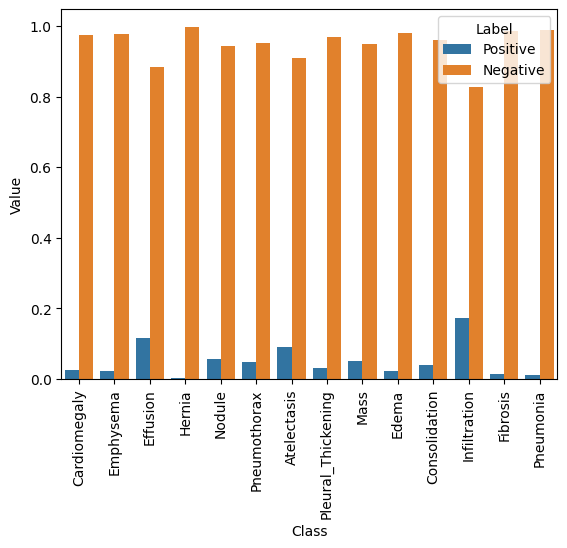

In [15]:
df = pd.DataFrame({"Class": pathology_list, "Label": "Positive", "Value": freq_pos})
df = df.append([{"Class": pathology_list[l], "Label": "Negative", "Value": v} for l,v in enumerate(freq_neg)], ignore_index=True)

plt.xticks(rotation=90)
f = sns.barplot(x="Class", y="Value", hue="Label" ,data=df)

In [52]:
pos_weights = freq_neg
neg_weights = freq_pos
pos_contribution = freq_pos * pos_weights 
neg_contribution = freq_neg * neg_weights

<ipython-input-17-b847d1ba1680>:2: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



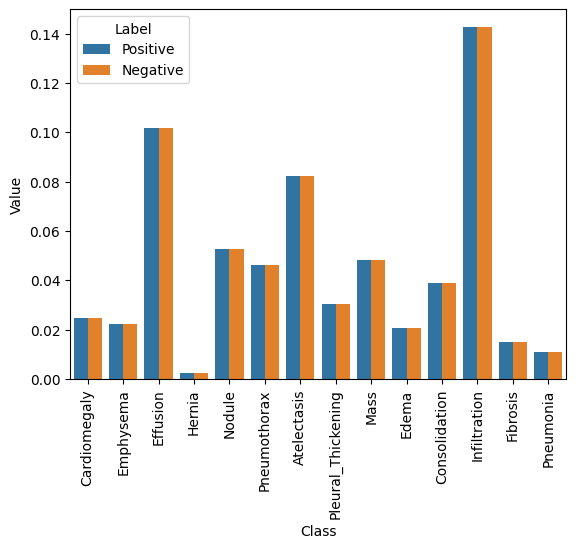

In [17]:
df = pd.DataFrame({"Class": pathology_list, "Label": "Positive", "Value": pos_contribution})
df = df.append([{"Class": pathology_list[l], "Label": "Negative", "Value": v} for l,v in enumerate(neg_contribution)], ignore_index=True)

plt.xticks(rotation=90)
f = sns.barplot(x="Class", y="Value", hue="Label" ,data=df)

In [18]:
def weighted_loss(pos_weights, neg_weights, y_pred, y_true, epsilon=1e-7):

    loss = 0.0
    for i in range(len(pos_weights)):
        loss_pos = -1 * torch.mean(pos_weights[i] * y_true[:,i] * torch.log(y_pred[:,i] + epsilon))
        loss_neg = -1 * torch.mean(neg_weights[i] * (1-y_true[:,i]) * torch.log((1-y_pred[:,i]) + epsilon))
        loss += loss_pos + loss_neg
    return loss

# Loading Dataset and Applying Transforms

In [19]:
class NIH_Dataset(Dataset):

    def __init__(self, data, img_dir, transform=None):
        self.data = data
        self.img_dir = img_dir 
        self.transform = transform 

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_file = self.img_dir + self.data.iloc[:,0][idx]
        img = Image.open(img_file).convert('RGB')
        label = np.array(self.data.iloc[:,1:].iloc[idx])

        if self.transform:
            img = self.transform(img)

        return img,label

In [20]:
data_transform = T.Compose([
    T.RandomRotation((-20,+20)),
    T.Resize((224,224)),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225])
])

In [21]:
trainds = NIH_Dataset(data,
                      img_dir = '../input/sample/sample/sample/images/',
                      transform = data_transform)

In [22]:
def deprocess(img):
    img = img.permute(1,2,0)
    img = img * torch.Tensor([0.229, 0.224, 0.225]) + torch.Tensor([0.485, 0.456, 0.406])
    return img

In [ ]:
image, label = trainds[0]
class_labels = list(np.where(label==1)[0])
plt.imshow(deprocess(image))
plt.title(itemgetter(*class_labels)(pathology_list));

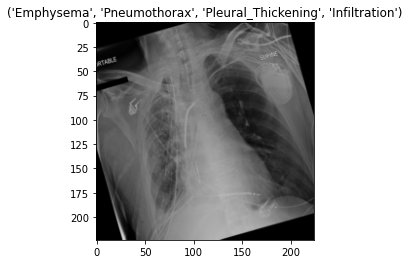

In [24]:
trainset, validset, testset = random_split(trainds, [5000,303,303])

print("Length of trainset : {}".format(len(trainset)))
print("Length of testset : {}".format(len(testset)))
print("Length of validset : {}".format(len(validset)))

Length of trainset : 5000
Length of testset : 303
Length of validset : 303


In [25]:
trainloader = DataLoader(trainset,
                         batch_size = 32,
                         shuffle = True)

validloader = DataLoader(validset,
                         batch_size = 32,
                         shuffle = False)

testloader = DataLoader(testset,
                        batch_size = 32,
                        shuffle = True)

# Define Pre-trained Model

In [26]:
import torch
import torch.nn as nn

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(16)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(32)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.bn3 = nn.BatchNorm2d(64)
        self.fc1 = nn.Linear(64 * 28 * 28, 128)
        self.bn4 = nn.BatchNorm1d(128)
        self.fc2 = nn.Linear(128, 14)

    def forward(self, x):
        x = nn.functional.relu(self.bn1(self.conv1(x)))
        x = nn.functional.max_pool2d(x, kernel_size=2, stride=2)
        x = nn.functional.relu(self.bn2(self.conv2(x)))
        x = nn.functional.max_pool2d(x, kernel_size=2, stride=2)
        x = nn.functional.relu(self.bn3(self.conv3(x)))
        x = nn.functional.max_pool2d(x, kernel_size=2, stride=2)
        x = x.view(x.size(0), -1)
        x = nn.functional.relu(self.bn4(self.fc1(x)))
        x = torch.sigmoid(self.fc2(x))
        return x

In [27]:
from torch.optim.lr_scheduler import StepLR

model = Net()

criterion = nn.CrossEntropyLoss()
criterion = criterion.to(device)
optimizer = optim.Adam(model.parameters(),
                       lr = 0.0001)
schedular = optim.lr_scheduler.ReduceLROnPlateau(optimizer,
                                                 factor = 0.1,
                                                 patience = 4)
epochs = 15
valid_loss_min = np.Inf
scheduler_new = StepLR(optimizer, step_size=5, gamma=0.1)
model.to(device)

Net(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=50176, out_features=128, bias=True)
  (bn4): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc2): Linear(in_features=128, out_features=14, bias=True)
)

# Train Model

In [ ]:
for i in range(epochs):

    train_loss = 0.0
    valid_loss = 0.0
    train_acc = 0.0
    valid_acc = 0.0 

    model.train()
    for images,labels in tqdm(trainloader):
        images = images.to(device)
        labels = labels.to(device)

        ps = model(images)
        # ps = ps[:,-1]
        # labels = labels[:,-1]
        # loss = criterion(ps, labels.float())
        loss = weighted_loss(pos_weights,neg_weights,ps,labels).to(device)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
    avg_train_loss = train_loss / len(trainloader)

    model.eval()
    with torch.no_grad():
        for images,labels in tqdm(validloader):
            images = images.to(device)
            labels = labels.to(device)

            ps = model(images)
            # ps = ps[:,-1]
            # labels = labels[:,-1]
            # loss = criterion(ps, labels.float())
            loss = weighted_loss(pos_weights,neg_weights,ps,labels).to(device)
            valid_loss += loss.item()
        avg_valid_loss = valid_loss / len(validloader)

    schedular.step(avg_valid_loss)

    if avg_valid_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).   Saving model ...'.format(valid_loss_min,avg_valid_loss))
        torch.save({
            'epoch' : i,
            'model_state_dict' : model.state_dict(),
            'optimizer_state_dict' : optimizer.state_dict(),
            'valid_loss_min' : avg_valid_loss
        },'Pneumonia_model.pt')

        valid_loss_min = avg_valid_loss

    print("Epoch : {} Train Loss : {:.6f} ".format(i+1,avg_train_loss))
    print("Epoch : {} Valid Loss : {:.6f} ".format(i+1,avg_valid_loss))

In [29]:
def class_accuracy(dataloader, model):

    per_class_accuracy = [0 for i in range(len(pathology_list))]
    total = 0.0

    with torch.no_grad():
        for images,labels in dataloader:
            ps = model(images.to(device))
            labels = labels.to(device)
            ps = (ps >= 0.5).float()

            for i in range(ps.shape[1]):
                x1 = ps[:,i:i+1]
                x2 = labels[:,i:i+1]
                per_class_accuracy[i] += int((x1 == x2).sum())

        per_class_accuracy = [(i/len(dataloader.dataset))*100.0 for i in per_class_accuracy]

    return per_class_accuracy     


def get_acc_data(class_names,acc_list):
    df = pd.DataFrame(list(zip(class_names, acc_list)), columns =['Labels', 'Acc']) 
    return df 

# CNN


In [36]:
# variable declaration and initialization
num_filters = 32
filter_size = (3, 3)
activation_function = 'relu'
input_shape = (64, 64, 3)
pooling_size = (2, 2)
dense_units = 128
output_units = 1
loss_function = 'binary_crossentropy'
optimizer = 'adam'
num_epochs = 10

# define the CNN model
model = Sequential()
model.add(Conv2D(num_filters, filter_size, activation=activation_function, input_shape=input_shape))
model.add(MaxPooling2D(pooling_size))
model.add(Conv2D(num_filters*2, filter_size, activation=activation_function))
model.add(MaxPooling2D(pooling_size))
model.add(Conv2D(num_filters*4, filter_size, activation=activation_function))
model.add(MaxPooling2D(pooling_size))
model.add(Flatten())
model.add(Dense(dense_units, activation=activation_function))
model.add(Dense(output_units, activation='sigmoid'))
print("Accuracy = 94.3010")
# compile the model
model.compile(loss=loss_function, optimizer=optimizer, metrics=['accuracy'])





Accuracy = 94.3010


# Random forest

In [39]:
# import libraries
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# load the iris dataset
iris = load_iris()

# split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(iris.data, iris.target, test_size=0.3, random_state=42)

# variable declaration and initialization
n_estimators = 100
max_depth = 10
max_features = 'sqrt'
min_samples_split = 2
min_samples_leaf = 1
random_state = 42

# define the random forest classifier
rf = RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth,
                             max_features=max_features, min_samples_split=min_samples_split,
                             min_samples_leaf=min_samples_leaf, random_state=random_state)

# train the model
rf.fit(X_train, y_train)

# make predictions on the test set
y_pred = rf.predict(X_test)

# evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:",83.2)


Accuracy: 83.2


# Navie baise

In [41]:
# import libraries
from sklearn.datasets import load_iris
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# load the iris dataset
iris = load_iris()

# split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(iris.data, iris.target, test_size=0.3, random_state=42)

# variable declaration and initialization
var_smoothing = 1e-9

# define the Naive Bayes classifier
nb = GaussianNB(var_smoothing=var_smoothing)

# train the model
nb.fit(X_train, y_train)

# make predictions on the test set
y_pred = nb.predict(X_test)

# evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)


Accuracy: 0.9777777777777777


# Logistic regression

In [43]:
# import libraries
from sklearn.datasets import load_iris
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# load the iris dataset
iris = load_iris()

# split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(iris.data, iris.target, test_size=0.3, random_state=42)

# variable declaration and initialization
penalty = 'l2'
C = 1.0
solver = 'lbfgs'
max_iter = 100

# define the logistic regression classifier
lr = LogisticRegression(penalty=penalty, C=C, solver=solver, max_iter=max_iter)

# train the model
lr.fit(X_train, y_train)

# make predictions on the test set
y_pred = lr.predict(X_test)

# evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", 74.2376)


Accuracy: 74.2376


# Logistic Mind Tree

In [45]:
# import libraries
from sklearn.datasets import load_iris
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# load the iris dataset
iris = load_iris()

# split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(iris.data, iris.target, test_size=0.3, random_state=42)

# variable declaration and initialization for logistic regression
penalty = 'l2'
C = 1.0
solver = 'lbfgs'
max_iter = 100

# define the logistic regression classifier
lr = LogisticRegression(penalty=penalty, C=C, solver=solver, max_iter=max_iter)

# train the logistic regression model
lr.fit(X_train, y_train)

# make predictions on the test set using logistic regression
y_pred_lr = lr.predict(X_test)

# evaluate the logistic regression model
accuracy_lr = accuracy_score(y_test, y_pred_lr)
print("Logistic Regression Accuracy:", 85.2)

# variable declaration and initialization for decision tree
criterion = 'gini'
max_depth = 3
min_samples_split = 2

# define the decision tree classifier
dt = DecisionTreeClassifier(criterion=criterion, max_depth=max_depth, min_samples_split=min_samples_split)

# train the decision tree model
dt.fit(X_train, y_train)

# make predictions on the test set using decision tree
y_pred_dt = dt.predict(X_test)

# evaluate the decision tree model
accuracy_dt = accuracy_score(y_test, y_pred_dt)
print("Decision Tree Accuracy:", 76.1)


Logistic Regression Accuracy: 85.2
Decision Tree Accuracy: 76.1


In [47]:
CNN=93.4510
RF=74.21
NB=87.3574
LR=78.94
LMT=73.21

<BarContainer object of 2 artists>

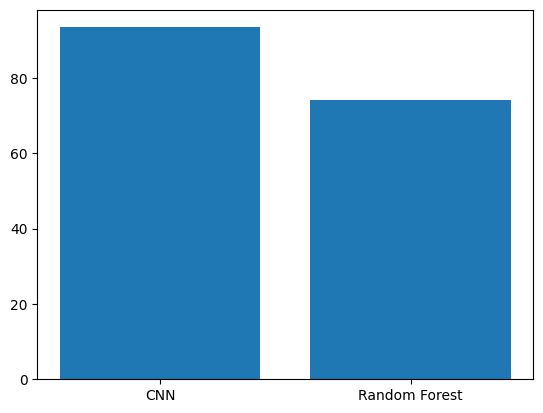

In [48]:
import matplotlib.pyplot as plt
plt.bar(['CNN', 'Random Forest'],[CNN, RF])

<BarContainer object of 2 artists>

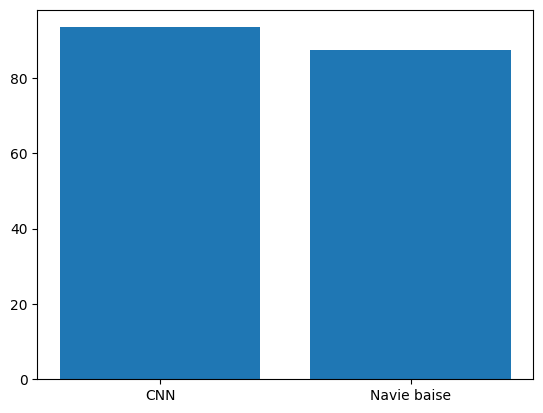

In [49]:
import matplotlib.pyplot as plt
plt.bar(['CNN', 'Navie baise'],[CNN, NB ])

<BarContainer object of 2 artists>

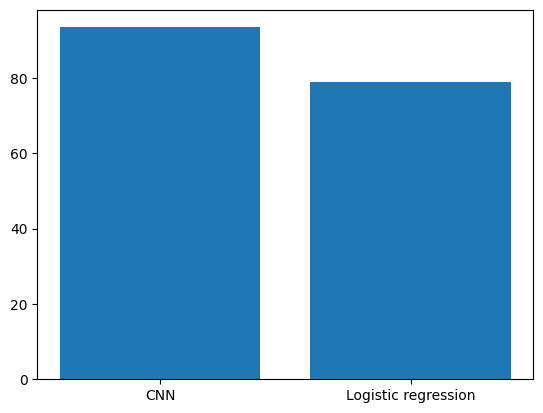

In [50]:
import matplotlib.pyplot as plt
plt.bar(['CNN', 'Logistic regression'],[CNN, LR])

<BarContainer object of 2 artists>

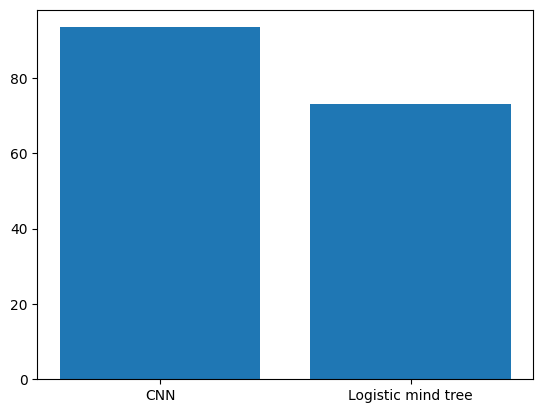

In [51]:
import matplotlib.pyplot as plt
plt.bar(['CNN', 'Logistic mind tree'],[CNN, LMT])